In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
import patsy

from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from pysal.model import mgwr
from mgwr.sel_bw import Sel_BW

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [3]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

In [4]:
gz_station=gpd.read_file('metro_data/广州/station.shp',encoding="utf-8")
gz_line=gpd.read_file('metro_data/广州/line.shp',encoding="utf-8")

In [5]:
sz_station=gpd.read_file('metro_data/深圳/station.shp',encoding="utf-8")
sz_line=gpd.read_file('metro_data/深圳/line.shp',encoding="utf-8")

In [6]:
dg_station=gpd.read_file('metro_data/东莞/station.shp',encoding="utf-8")
dg_line=gpd.read_file('metro_data/东莞/line.shp',encoding="utf-8")

In [7]:
fs_station=gpd.read_file('metro_data/佛山/station.shp',encoding="utf-8")
fs_line=gpd.read_file('metro_data/佛山/line.shp',encoding="utf-8")

In [8]:
gz_line['service_time']=['1015','1015','1040','1050','990','1015','1015','1050','1010','1010','985','1010','1010','990']

In [9]:
##node1 bus stop count
gz_area=gpd.read_file('metro_data/广州/gz_area.shp',encoding="utf-8")

In [10]:
gz_area.head()

,id,time,line_name,station_na,lng84,lat84,area,geometry
0,1,15,??1??(??--????),??,113.22665366084165,23.068138134411758,1970009,"POLYGON ((113.22565 23.07944, 113.22765 23.076..."
1,2,15,??1??(??--????),??,113.2271730697168,23.081573783272855,2193001,"POLYGON ((113.22817 23.09182, 113.22957 23.090..."
2,3,15,??1??(??--????),???,113.22870537148827,23.089748291208767,2224351,"POLYGON ((113.23071 23.10102, 113.23018 23.099..."
3,4,15,??1??(??--????),??,113.2303784246444,23.10128141365814,2827239,"POLYGON ((113.22538 23.10876, 113.22616 23.107..."
4,5,15,??1??(??--????),??,113.23453220953868,23.11321036550148,2423683,"POLYGON ((113.23753 23.12345, 113.23795 23.122..."


In [11]:
gz_area = pd.merge(gz_area, gz_station, on='lng84')

In [12]:
gz_area=gz_area.drop(['time','line_name_x','station_na_x','lat84_y','geometry_y'],axis=1)

In [13]:
gz_area.rename(columns=
{
"lat84_x": "lat84",
"geometry_x": "geometry",
"line_name_y": "line_name",
"station_na_y": "station_name"
}, inplace=True)

In [14]:
gz_bus_station=gpd.read_file('metro_data/广州/amap_bus_stops_gz.shp',encoding="utf-8")
gz_bus_line=gpd.read_file('metro_data/广州/amap_bus_lines_gz.shp',encoding="utf-8")

In [15]:
gz_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            200 non-null    int64   
 1   lng84         200 non-null    object  
 2   lat84         200 non-null    object  
 3   area          200 non-null    int64   
 4   geometry      200 non-null    geometry
 5   line_name     200 non-null    object  
 6   station_name  200 non-null    object  
 7   lng           200 non-null    object  
 8   lat           200 non-null    object  
dtypes: geometry(1), int64(2), object(6)
memory usage: 15.6+ KB


In [16]:
gz_bus_station_count = gpd.sjoin(gz_bus_station, gz_area, how='right')
gz_bus_station_count_test = gz_bus_station_count.groupby(['station_name'])['stop_id'].agg(busStop_Count='count').reset_index() 

In [17]:
gz_area = pd.merge(gz_area, gz_bus_station_count_test, on='station_name')

In [18]:
#node2_service time
gz_area = pd.merge(gz_area, gz_line, on='line_name')

In [19]:
gz_area=gz_area.drop(['start_time','end_time','start_stop','end_stop','distance','basic_pric','total_pric','geometry_y'],axis=1)

In [20]:
gz_area.rename(columns={"geometry_x":"geometry"},inplace=True)

In [21]:
gz_bus_line.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2937 entries, 0 to 2936
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Id          2937 non-null   int64   
 1   amap_id     2937 non-null   object  
 2   name        2937 non-null   object  
 3   type        2937 non-null   object  
 4   startTime   2937 non-null   object  
 5   endTime     2937 non-null   object  
 6   company     2937 non-null   object  
 7   distance    2937 non-null   float64 
 8   basicPrice  2937 non-null   float64 
 9   totalPrice  2937 non-null   float64 
 10  stopsCnt    2937 non-null   int64   
 11  geometry    2937 non-null   geometry
dtypes: float64(3), geometry(1), int64(2), object(6)
memory usage: 275.5+ KB


In [22]:
#NODE3 bus line density
gz_busline_within_area = pd.read_csv('metro_data/广州/test.csv',low_memory=False, encoding="utf-8",
                 usecols=['station_na','LENGTH',"COUNT","id"])
area = pd.read_csv('metro_data/广州/area.csv',low_memory=False, encoding="utf-8",
                 usecols=['area',"id"])

In [23]:
area.head()

,id,area
0,1,1970009
1,2,2193001
2,3,2224351
3,4,2827239
4,5,2423683


In [24]:
area = pd.merge(area, gz_busline_within_area, on='id')

In [25]:
gz_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             200 non-null    int64   
 1   lng84          200 non-null    object  
 2   lat84          200 non-null    object  
 3   area           200 non-null    int64   
 4   geometry       200 non-null    geometry
 5   line_name      200 non-null    object  
 6   station_name   200 non-null    object  
 7   lng            200 non-null    object  
 8   lat            200 non-null    object  
 9   busStop_Count  200 non-null    int64   
 10  service_time   200 non-null    object  
dtypes: geometry(1), int64(3), object(7)
memory usage: 18.8+ KB


In [26]:
gz_area =gz_area.astype({"lng84":'float', "lat84":'float',"line_name":'string',"station_name":'string',"service_time":'int'})

In [27]:
area['busLine_Density']=area.area/area.LENGTH

In [28]:
gz_area = pd.merge(gz_area, area, on='id')

In [29]:
gz_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id               200 non-null    int64   
 1   lng84            200 non-null    float64 
 2   lat84            200 non-null    float64 
 3   area_x           200 non-null    int64   
 4   geometry         200 non-null    geometry
 5   line_name        200 non-null    string  
 6   station_name     200 non-null    string  
 7   lng              200 non-null    object  
 8   lat              200 non-null    object  
 9   busStop_Count    200 non-null    int64   
 10  service_time     200 non-null    int64   
 11  area_y           200 non-null    int64   
 12  station_na       200 non-null    object  
 13  LENGTH           200 non-null    float64 
 14  COUNT            200 non-null    int64   
 15  busLine_Density  200 non-null    float64 
dtypes: float64(4), geometry(1), int64(6)

In [30]:
gz_area= gz_area.drop(['station_na','LENGTH','COUNT'],axis=1)

In [31]:
#NODE4 service direction number
gz_area['Service_direction']=1

In [32]:
gz_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 200 non-null    int64   
 1   lng84              200 non-null    float64 
 2   lat84              200 non-null    float64 
 3   area_x             200 non-null    int64   
 4   geometry           200 non-null    geometry
 5   line_name          200 non-null    string  
 6   station_name       200 non-null    string  
 7   lng                200 non-null    object  
 8   lat                200 non-null    object  
 9   busStop_Count      200 non-null    int64   
 10  service_time       200 non-null    int64   
 11  area_y             200 non-null    int64   
 12  busLine_Density    200 non-null    float64 
 13  Service_direction  200 non-null    int64   
dtypes: float64(3), geometry(1), int64(6), object(2), string(2)
memory usage: 23.4+ KB


In [33]:
station_list=['公园前','体育西路','广州东站','杨箕','黄沙','东山口','陈家祠','西塱','广州火车站','海珠广场','石壁','广州南站','昌岗','南洲','珠江新城','燕塘','天河客运站','汉溪长隆'
             ,'客村','高增','沥滘','林和西','广州塔','车陂南','大学城南','万胜围','黄村','坦尾','区庄','鱼珠','员村','文化公园','苏元','沙园','镇龙']
for i in station_list:
    gz_area.Service_direction[gz_area[gz_area['station_name']==i]['Service_direction'].index.values]=2

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/envs/sds2020/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [34]:
gz_area.Service_direction[gz_area[gz_area['station_name']=='嘉禾望岗']['Service_direction'].index.values]=3

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
#place1-poi_count
gz_poi_total=gpd.read_file('metro_data/广州/poi_total.shp',encoding="utf-8")

In [36]:
gz_area2=gz_area.copy()

In [37]:
gz_poi_total_count = gpd.sjoin(gz_poi_total, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(poi_Count='count').reset_index() 

In [38]:
gz_poi_total_count_test.head()

,station_name,poi_Count
0,一德路,2763
1,万胜围,21
2,三溪,316
3,上步,448
4,东圃,151


In [39]:
gz_area = pd.merge(gz_area, gz_poi_total_count_test, on='station_name')

In [40]:
gz_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 200 non-null    int64   
 1   lng84              200 non-null    float64 
 2   lat84              200 non-null    float64 
 3   area_x             200 non-null    int64   
 4   geometry           200 non-null    geometry
 5   line_name          200 non-null    string  
 6   station_name       200 non-null    object  
 7   lng                200 non-null    object  
 8   lat                200 non-null    object  
 9   busStop_Count      200 non-null    int64   
 10  service_time       200 non-null    int64   
 11  area_y             200 non-null    int64   
 12  busLine_Density    200 non-null    float64 
 13  Service_direction  200 non-null    int64   
 14  poi_Count          200 non-null    int64   
dtypes: float64(3), geometry(1), int64(7), object(3), 

In [41]:
#place2-Simpson Diversity Index(poi)

In [42]:
def simpson_di(data):

    """ Given a hash { 'species': count } , returns the Simpson Diversity Index
    
    >>> simpson_di({'a': 10, 'b': 20, 'c': 30,})
    0.3888888888888889
    """

    N = sum(data.values())
    
    def p(n, N):
        """ Relative abundance """
        if n is  0:
            return 0
        else:
            return (float(n)*(n-1))/(N*(N-1))

    
    return 1-sum(p(n, N) for n in data.values() if n is not 0)

In [43]:
simpson_di({'a':3,'b':2,'c':0})

0.6

In [44]:
gz_poi_cy=gpd.read_file('metro_data/广州/poi/广州市_餐饮.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_cy, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(cy_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [45]:
gz_poi_ds=gpd.read_file('metro_data/广州/poi/广州市_大厦.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_ds, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(ds_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [46]:
gz_poi_mall=gpd.read_file('metro_data/广州/poi/广州市_大型购物广场.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_mall, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(mall_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [47]:
gz_poi_gw=gpd.read_file('metro_data/广州/poi/广州市_购物.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_gw, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(gw_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [48]:
gz_poi_jr=gpd.read_file('metro_data/广州/poi/广州市_金融服务.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_jr, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(jr_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [49]:
gz_poi_ky=gpd.read_file('metro_data/广州/poi/广州市_科研教育.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_ky, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(ky_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [50]:
gz_poi_ly=gpd.read_file('metro_data/广州/poi/广州市_旅游.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_ly, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(ly_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [51]:
gz_poi_xs=gpd.read_file('metro_data/广州/poi/广州市_休闲娱乐.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_xs, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(xs_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [52]:
gz_poi_zf=gpd.read_file('metro_data/广州/poi/广州市_政府机关.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_zf, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(zf_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [53]:
gz_poi_zs=gpd.read_file('metro_data/广州/poi/广州市_住宿.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_zs, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(zs_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [54]:
gz_poi_zj=gpd.read_file('metro_data/广州/poi/广州市_宗教点.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_zj, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(zj_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [55]:
gz_area2.head()

,id,lng84,lat84,area_x,geometry,line_name,station_name,lng,lat,busStop_Count,...,ds_Count,mall_Count,gw_Count,jr_Count,ky_Count,ly_Count,xs_Count,zf_Count,zs_Count,zj_Count
0,1,113.2267,23.0681,1970009,"POLYGON ((113.22565 23.07944, 113.22765 23.076...",地铁1号线(西塱--广州东站),西塱,113.231978,23.065437,266,...,3,9,111,10,18,0,18,2,6,0
1,2,113.2272,23.0816,2193001,"POLYGON ((113.22817 23.09182, 113.22957 23.090...",地铁1号线(西塱--广州东站),坑口,113.232498,23.078878,314,...,8,8,342,26,19,0,37,16,4,0
2,3,113.2287,23.0897,2224351,"POLYGON ((113.23071 23.10102, 113.23018 23.099...",地铁1号线(西塱--广州东站),花地湾,113.23403,23.087055,403,...,12,25,602,43,30,0,93,20,16,0
3,4,113.2304,23.1013,2827239,"POLYGON ((113.22538 23.10876, 113.22616 23.107...",地铁1号线(西塱--广州东站),芳村,113.235703,23.098592,468,...,9,28,742,54,49,6,115,16,27,0
4,5,113.2345,23.1132,2423683,"POLYGON ((113.23753 23.12345, 113.23795 23.122...",地铁1号线(西塱--广州东站),黄沙,113.239856,23.110524,340,...,6,27,991,79,44,13,134,53,45,0


In [56]:
gz_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 200 non-null    int64   
 1   lng84              200 non-null    float64 
 2   lat84              200 non-null    float64 
 3   area_x             200 non-null    int64   
 4   geometry           200 non-null    geometry
 5   line_name          200 non-null    string  
 6   station_name       200 non-null    object  
 7   lng                200 non-null    object  
 8   lat                200 non-null    object  
 9   busStop_Count      200 non-null    int64   
 10  service_time       200 non-null    int64   
 11  area_y             200 non-null    int64   
 12  busLine_Density    200 non-null    float64 
 13  Service_direction  200 non-null    int64   
 14  poi_Count          200 non-null    int64   
dtypes: float64(3), geometry(1), int64(7), object(3), 

In [57]:
gz_area['poi_Diversity']=0.1

In [58]:
for i in range(0,199):
    poi_dic={'a':gz_area2['cy_Count'][i],'b':gz_area2['ds_Count'][i],'c':gz_area2['mall_Count'][i],
             'd':gz_area2['gw_Count'][i],'e':gz_area2['jr_Count'][i],'f':gz_area2['ky_Count'][i],
             'g':gz_area2['ly_Count'][i],'h':gz_area2['xs_Count'][i],'i':gz_area2['zf_Count'][i],
             'j':gz_area2['zs_Count'][i],'k':gz_area2['zj_Count'][i]}
    gz_area['poi_Diversity'][i]=simpson_di(poi_dic)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [59]:
gz_area['poi_Diversity'] = gz_area['poi_Diversity'].fillna(0)

In [60]:
#Settlement1 community_center count
gz_poi_community=gpd.read_file('metro_data/广州/poi/广州市_居委会点.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_community, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(community_Count='count').reset_index()
gz_area = pd.merge(gz_area, gz_poi_total_count_test, on='station_name')

In [61]:
#Settlement2 residence count
gz_poi_residence=gpd.read_file('metro_data/广州/poi/广州市_居民小区点.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_community, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(residence_Count='count').reset_index()
gz_area = pd.merge(gz_area, gz_poi_total_count_test, on='station_name')

In [62]:
gz_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 200 non-null    int64   
 1   lng84              200 non-null    float64 
 2   lat84              200 non-null    float64 
 3   area_x             200 non-null    int64   
 4   geometry           200 non-null    geometry
 5   line_name          200 non-null    string  
 6   station_name       200 non-null    object  
 7   lng                200 non-null    object  
 8   lat                200 non-null    object  
 9   busStop_Count      200 non-null    int64   
 10  service_time       200 non-null    int64   
 11  area_y             200 non-null    int64   
 12  busLine_Density    200 non-null    float64 
 13  Service_direction  200 non-null    int64   
 14  poi_Count          200 non-null    int64   
 15  poi_Diversity      200 non-null    float64 
 16  

In [63]:
#container1 building height
gz_building_within_area = pd.read_csv('metro_data/广州/building_area.csv',low_memory=False, encoding="utf-8",
                 usecols=['height','build_area',"id",'area'])

In [64]:
gz_building_within_area.head()

,height,id,area,build_area
0,12.0000,151,3135172,531.8490
1,36.0000,151,3135172,565.1530
2,12.0000,151,3135172,262.2590
3,12.0000,151,3135172,"1,359.2120"
4,12.0000,151,3135172,286.2510


In [65]:
gz_building_within_area['build_area'] = gz_building_within_area['build_area'].fillna(0)
gz_building_within_area['height'] = gz_building_within_area['height'].fillna(0)

In [66]:
gz_building_within_area[gz_building_within_area.id==151]

,height,id,area,build_area
0,12.0000,151,3135172,531.8490
1,36.0000,151,3135172,565.1530
2,12.0000,151,3135172,262.2590
3,12.0000,151,3135172,"1,359.2120"
4,12.0000,151,3135172,286.2510
...,...,...,...,...
465239,66.0000,151,3135172,0.0000
465240,4.0000,151,3135172,0.0000
465241,4.0000,151,3135172,0.0000
465242,4.0000,151,3135172,0.0000


In [67]:
gz_building_test = gz_building_within_area.groupby(['id'])['build_area'].agg(building_sum='sum').reset_index()

In [68]:
gz_building_test2 = gz_building_within_area.groupby(['id'])['height'].agg(height_avg='mean').reset_index()

In [69]:
gz_building_test.head()

,id,building_sum
0,1,0.0000
1,2,0.0000
2,3,0.0000
3,4,0.0000
4,5,0.0000


In [70]:
gz_area3 = pd.merge(gz_area, gz_building_test, on='id',how='left')

In [71]:
gz_area3 = pd.merge(gz_area3, gz_building_test2, on='id',how='left')

In [72]:
gz_area3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 200 non-null    int64   
 1   lng84              200 non-null    float64 
 2   lat84              200 non-null    float64 
 3   area_x             200 non-null    int64   
 4   geometry           200 non-null    geometry
 5   line_name          200 non-null    string  
 6   station_name       200 non-null    object  
 7   lng                200 non-null    object  
 8   lat                200 non-null    object  
 9   busStop_Count      200 non-null    int64   
 10  service_time       200 non-null    int64   
 11  area_y             200 non-null    int64   
 12  busLine_Density    200 non-null    float64 
 13  Service_direction  200 non-null    int64   
 14  poi_Count          200 non-null    int64   
 15  poi_Diversity      200 non-null    float64 
 16  

In [73]:
gz_area3['building_sum'] = gz_area3['building_sum'].fillna(0)
gz_area3['height_avg'] = gz_area3['height_avg'].fillna(0)

In [74]:
gz_area3=gz_area3.drop(['area_y'],axis=1)
gz_area3.rename(columns={'area_x':'area'},inplace=True)

In [75]:
gz_cor=gz_area3.copy()

In [76]:
gz_cor= gz_cor.drop(['id','lng84','lat84','geometry','line_name','station_name','lng','lat','area'],axis=1)

In [77]:
gz_cor.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   busStop_Count      200 non-null    int64  
 1   service_time       200 non-null    int64  
 2   busLine_Density    200 non-null    float64
 3   Service_direction  200 non-null    int64  
 4   poi_Count          200 non-null    int64  
 5   poi_Diversity      200 non-null    float64
 6   community_Count    200 non-null    int64  
 7   residence_Count    200 non-null    int64  
 8   building_sum       200 non-null    float64
 9   height_avg         200 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 17.2 KB


In [78]:
gz_cor.corr()

,busStop_Count,service_time,busLine_Density,Service_direction,poi_Count,poi_Diversity,community_Count,residence_Count,building_sum,height_avg
busStop_Count,1.0000,0.1376,-0.3330,0.1723,0.9074,-0.0514,0.8353,0.8353,0.4957,0.2164
service_time,0.1376,1.0000,-0.1848,0.1778,0.1219,-0.0319,0.0990,0.0990,0.2359,0.0099
busLine_Density,-0.3330,-0.1848,1.0000,-0.1079,-0.2518,0.0151,-0.1982,-0.1982,-0.1981,-0.2114
Service_direction,0.1723,0.1778,-0.1079,1.0000,0.1163,-0.0064,0.1405,0.1405,0.0044,0.0064
poi_Count,0.9074,0.1219,-0.2518,0.1163,1.0000,-0.0934,0.8834,0.8834,0.4738,0.2109
poi_Diversity,-0.0514,-0.0319,0.0151,-0.0064,-0.0934,1.0000,-0.1158,-0.1158,0.0419,0.1239
community_Count,0.8353,0.0990,-0.1982,0.1405,0.8834,-0.1158,1.0000,1.0000,0.3996,0.0789
residence_Count,0.8353,0.0990,-0.1982,0.1405,0.8834,-0.1158,1.0000,1.0000,0.3996,0.0789
building_sum,0.4957,0.2359,-0.1981,0.0044,0.4738,0.0419,0.3996,0.3996,1.0000,0.2704
height_avg,0.2164,0.0099,-0.2114,0.0064,0.2109,0.1239,0.0789,0.0789,0.2704,1.0000


<AxesSubplot:>

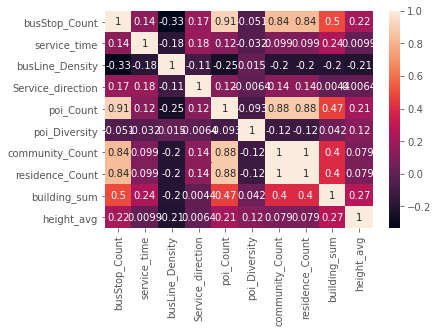

In [79]:
corrMatrix = gz_cor.corr()
sns_plot=sns.heatmap(corrMatrix, annot=True)
sns_plot

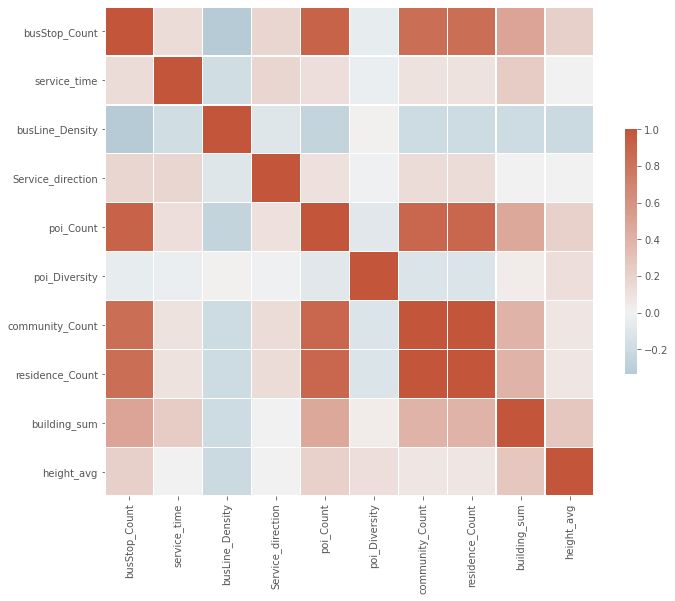

In [80]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot1=sns.heatmap(corrMatrix,  cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [81]:
plot1.figure.savefig("corr.png",dpi=300)

In [82]:
##增加的indicators
##修改-node 公交线路覆盖率
road_total = pd.read_csv('metro_data/广州/road_toal.csv',low_memory=False, encoding="utf-8",
                 usecols=['road_length',"id"])

In [83]:
road_total = pd.merge(road_total, gz_busline_within_area, on='id')

In [84]:
road_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           200 non-null    int64  
 1   road_length  200 non-null    float64
 2   station_na   200 non-null    object 
 3   LENGTH       200 non-null    float64
 4   COUNT        200 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 9.4+ KB


In [85]:
road_total['busLine_Coverage']=road_total.LENGTH/road_total.road_length

In [86]:
gz_area3 = pd.merge(gz_area3, road_total, on='id',how='left')

In [87]:
gz_area3= gz_area3.drop(['station_na','LENGTH','COUNT','busLine_Density'],axis=1)

In [88]:
gz_area3.head()

,id,lng84,lat84,area,geometry,line_name,station_name,lng,lat,busStop_Count,service_time,Service_direction,poi_Count,poi_Diversity,community_Count,residence_Count,building_sum,height_avg,road_length,busLine_Coverage
0,1,113.2267,23.0681,1970009,"POLYGON ((113.22565 23.07944, 113.22765 23.076...",地铁1号线(西塱--广州东站),西塱,113.231978,23.065437,266,1015,2,195,0.6477,3,3,0.0000,15.6406,"27,290.1233",4.9863
1,2,113.2272,23.0816,2193001,"POLYGON ((113.22817 23.09182, 113.22957 23.090...",地铁1号线(西塱--广州东站),坑口,113.232498,23.078878,314,1015,1,507,0.5265,2,2,0.0000,14.8217,"42,401.8466",4.8030
2,3,113.2287,23.0897,2224351,"POLYGON ((113.23071 23.10102, 113.23018 23.099...",地铁1号线(西塱--广州东站),花地湾,113.23403,23.087055,403,1015,1,990,0.5951,3,3,0.0000,14.8139,"40,325.4361",6.3319
3,4,113.2304,23.1013,2827239,"POLYGON ((113.22538 23.10876, 113.22616 23.107...",地铁1号线(西塱--广州东站),芳村,113.235703,23.098592,468,1015,1,1221,0.5969,7,7,0.0000,16.0873,"50,933.2833",5.8260
4,5,113.2345,23.1132,2423683,"POLYGON ((113.23753 23.12345, 113.23795 23.122...",地铁1号线(西塱--广州东站),黄沙,113.239856,23.110524,340,1015,2,1707,0.6183,18,18,0.0000,20.8820,"60,707.7252",4.0000


In [89]:
gz_area3.rename(columns=
{
"busStop_Count": "N_busStop_count",
"service_time": "N_service_time",
"Service_direction": "N_service_direc",
"busLine_Coverage": "N_busLine_Coverage",
"poi_Diversity": "P_poi_Diversity",
"community_Count": "S_community_Count",
"height_avg": "C_height_avg"
}, inplace=True)

In [90]:
gz_area3['C_building_density']=gz_area3.building_sum/gz_area3.area

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [91]:
gz_area3= gz_area3.drop(['poi_Count','residence_Count','building_sum'],axis=1)

In [92]:
#node-对外交通道路所占比例
external_road = pd.read_csv('metro_data/广州/external_road.csv',low_memory=False, encoding="utf-8",
                 usecols=['external_length',"id"])
external_road = pd.merge(external_road, road_total, on='id')
external_road['N_external_Coverage']=external_road.external_length/external_road.road_length

In [93]:
external_road.head()

,id,external_length,road_length,station_na,LENGTH,COUNT,busLine_Coverage,N_external_Coverage
0,1,"9,525.3717","27,290.1233",??,"136,077.9080",76,4.9863,0.3490
1,2,"12,093.3320","42,401.8466",??,"203,655.7793",99,4.8030,0.2852
2,3,"18,278.0977","40,325.4361",???,"255,334.7997",123,6.3319,0.4533
3,4,"13,210.1644","50,933.2833",??,"296,738.2172",129,5.8260,0.2594
4,5,"5,416.1238","60,707.7252",??,"242,830.4837",156,4.0000,0.0892


In [94]:
#community-对内交通道路所占比例
internal_road = pd.read_csv('metro_data/广州/internal_road.csv',low_memory=False, encoding="utf-8",
                 usecols=['internal_length',"id"])
internal_road = pd.merge(internal_road, external_road, on='id')
internal_road['C_internal_Coverage']=internal_road.internal_length/internal_road.road_length

In [95]:
gz_area3 = pd.merge(gz_area3, internal_road, on='id',how='left')

In [96]:
gz_area3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   200 non-null    int64   
 1   lng84                200 non-null    float64 
 2   lat84                200 non-null    float64 
 3   area                 200 non-null    int64   
 4   geometry             200 non-null    geometry
 5   line_name            200 non-null    string  
 6   station_name         200 non-null    object  
 7   lng                  200 non-null    object  
 8   lat                  200 non-null    object  
 9   N_busStop_count      200 non-null    int64   
 10  N_service_time       200 non-null    int64   
 11  N_service_direc      200 non-null    int64   
 12  P_poi_Diversity      200 non-null    float64 
 13  S_community_Count    200 non-null    int64   
 14  C_height_avg         200 non-null    float64 
 15  road_length_x  

In [97]:
gz_area3= gz_area3.drop(['station_na','LENGTH','COUNT','busLine_Coverage','internal_length','external_length','road_length_y'],axis=1)

In [98]:
gz_area3.rename(columns=
{
"C_internal_Coverage": "S_internal_Coverage"
}, inplace=True)

In [99]:
#Contaner-道路网密度
gz_area3['C_road_density']=gz_area3.road_length_x/gz_area3.area

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [100]:
#place-范围内人口总数
pop_area = pd.read_csv('metro_data/广州/pop_area.csv',low_memory=False, encoding="utf-8",
                 usecols=['pop',"id"])

In [101]:
gz_pop = pop_area.groupby(['id'])['pop'].agg(P_pop_sum='sum').reset_index()

In [102]:
gz_area3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   200 non-null    int64   
 1   lng84                200 non-null    float64 
 2   lat84                200 non-null    float64 
 3   area                 200 non-null    int64   
 4   geometry             200 non-null    geometry
 5   line_name            200 non-null    string  
 6   station_name         200 non-null    object  
 7   lng                  200 non-null    object  
 8   lat                  200 non-null    object  
 9   N_busStop_count      200 non-null    int64   
 10  N_service_time       200 non-null    int64   
 11  N_service_direc      200 non-null    int64   
 12  P_poi_Diversity      200 non-null    float64 
 13  S_community_Count    200 non-null    int64   
 14  C_height_avg         200 non-null    float64 
 15  road_length_x  

In [103]:
gz_area3 = pd.merge(gz_area3, gz_pop, on='id',how='left')

In [104]:
#node-交通用地占比/place-基本功能占比/非基本功能占比
basic_function = pd.read_csv('metro_data/广州/basic_function.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id"])
unbasic_function = pd.read_csv('metro_data/广州/unbasic_function.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id"])
transpotation_function = pd.read_csv('metro_data/广州/transpotation_function.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id"])

In [105]:
basic_function = basic_function.groupby(['id'])['LU_area'].agg(basic_sum='sum').reset_index()
unbasic_function = unbasic_function.groupby(['id'])['LU_area'].agg(unbasic_sum='sum').reset_index()
transpotation_function = transpotation_function.groupby(['id'])['LU_area'].agg(transpotation_sum='sum').reset_index()

In [106]:
basic_function.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         188 non-null    int64  
 1   basic_sum  188 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.1 KB


In [107]:
gz_area3 = pd.merge(gz_area3, basic_function, on='id',how='left')
gz_area3 = pd.merge(gz_area3, unbasic_function, on='id',how='left')
gz_area3 = pd.merge(gz_area3, transpotation_function, on='id',how='left')

In [108]:
gz_area3['N_transland_Cover']=gz_area3.transpotation_sum/gz_area3.area
gz_area3['P_basic_Cover']=gz_area3.basic_sum/gz_area3.area
gz_area3['N_unbasic_Cover']=gz_area3.unbasic_sum/gz_area3.area

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [109]:
gz_area3= gz_area3.drop(['transpotation_sum','basic_sum','unbasic_sum'],axis=1)

In [110]:
#Place-Degree of landuse mix---entropy 熵 Frank（2005）
landuse_area = pd.read_csv('metro_data/广州/landuse_area.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id",'area','Level1'])

In [111]:
test = landuse_area.groupby(['id','Level1'])['LU_area'].agg(LU_sum='sum').reset_index()

In [113]:
test1 = pd.pivot_table(test, index='id', columns='Level1', values='LU_sum')

In [114]:
test2 = pd.DataFrame(test1.to_records())

In [115]:
test2.head()

,id,1,2,3,4,5
0,1,"1,598,061.2456","176,130.7435","7,440.5641",nan,nan
1,2,"1,369,816.1970","216,773.4180","324,905.6377",nan,"5,000.6761"
2,3,"1,263,597.7167","381,829.4660","235,518.5467",nan,"5,000.6761"
3,4,"932,959.2297","277,263.8307","487,285.5904","407,058.6108","87,078.7169"
4,5,"969,764.2342","499,176.6885",nan,"358,505.6215","209,735.1890"


In [116]:
test_list=[]
for i in range (0,200):
    p=test2.loc[[i]].isna().sum().sum()
    test_list.append(p)

In [117]:
test2['na_vlaue']=test_list
test2['conf']=5
test2['n3']=test2.conf-test2.na_vlaue

In [118]:
test2['1'] = test2['1'].fillna(0)
test2['2'] = test2['2'].fillna(0)
test2['3'] = test2['3'].fillna(0)
test2['4'] = test2['4'].fillna(0)
test2['5'] = test2['5'].fillna(0)

In [119]:
test2['sum']=test2['1']+test2['2']+test2['3']+test2['4']+test2['5']

In [120]:
import math

In [121]:
test2.at[0,'1']

1598061.2456375537

In [122]:
(test2['sum'] != 0).all()

True

In [123]:
LUM_list=[]
for i in range (0,200):
    if test2.at[i,'1']==0:
        t1=0
    else:
        t1=math.log(test2.at[i,'1']/test2.at[i,'sum'])
    if test2.at[i,'2']==0:
        t2=0
    else:
        t2=math.log(test2.at[i,'2']/test2.at[i,'sum'])
    if test2.at[i,'3']==0:
        t3=0
    else:
        t3=math.log(test2.at[i,'3']/test2.at[i,'sum'])
    if test2.at[i,'4']==0:
        t4=0
    else:
        t4=math.log(test2.at[i,'4']/test2.at[i,'sum'])
    if test2.at[i,'5']==0:
        t5=0
    else:
        t5=math.log(test2.at[i,'5']/test2.at[i,'sum'])
    p=(-1)*((test2.at[i,'1']/test2.at[i,'sum'])*t1
                   +(test2.at[i,'2']/test2.at[i,'sum'])*t2
                  +(test2.at[i,'3']/test2.at[i,'sum'])*t3
                  +(test2.at[i,'4']/test2.at[i,'sum'])*t4
                  +(test2.at[i,'5']/test2.at[i,'sum'])*t5)/math.log(test2.at[i,'n3'])
    LUM_list.append(p)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


In [124]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        200 non-null    int64  
 1   1         200 non-null    float64
 2   2         200 non-null    float64
 3   3         200 non-null    float64
 4   4         200 non-null    float64
 5   5         200 non-null    float64
 6   na_vlaue  200 non-null    int64  
 7   conf      200 non-null    int64  
 8   n3        200 non-null    int64  
 9   sum       200 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 15.8 KB


In [125]:
test2['P_LUM']=LUM_list
test2['P_LUM'] = test2['P_LUM'].fillna(0)

In [126]:
LUM_df = test2[['id', 'P_LUM']]
gz_area3 = pd.merge(gz_area3, LUM_df, on='id',how='left')

In [129]:
gz_area3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   200 non-null    int64   
 1   lng84                200 non-null    float64 
 2   lat84                200 non-null    float64 
 3   area                 200 non-null    int64   
 4   geometry             200 non-null    geometry
 5   line_name            200 non-null    string  
 6   station_name         200 non-null    object  
 7   lng                  200 non-null    object  
 8   lat                  200 non-null    object  
 9   N_busStop_count      200 non-null    int64   
 10  N_service_time       200 non-null    int64   
 11  N_service_direc      200 non-null    int64   
 12  P_poi_Diversity      200 non-null    float64 
 13  S_community_Count    200 non-null    int64   
 14  C_height_avg         200 non-null    float64 
 15  road_length_x  

In [128]:
gz_area3['N_transland_Cover'] = gz_area3['N_transland_Cover'].fillna(0)
gz_area3['P_basic_Cover'] = gz_area3['P_basic_Cover'].fillna(0)
gz_area3['N_unbasic_Cover'] = gz_area3['N_unbasic_Cover'].fillna(0)

In [130]:
###测量correlation
gz_cor2=gz_area3.copy()
gz_cor2= gz_cor2.drop(['id','lng84','lat84','geometry','line_name','station_name','lng','lat','area','road_length_x'],axis=1)

,N_busStop_count,N_service_time,N_service_direc,P_poi_Diversity,S_community_Count,C_height_avg,N_busLine_Coverage,C_building_density,N_external_Coverage,S_internal_Coverage,C_road_density,P_pop_sum,N_transland_Cover,P_basic_Cover,N_unbasic_Cover,P_LUM
N_busStop_count,1.0000,0.1376,0.1723,-0.0514,0.8353,0.2164,0.5907,0.3769,-0.0811,0.0045,0.5971,0.7918,-0.1908,-0.1181,0.2638,0.2442
N_service_time,0.1376,1.0000,0.1778,-0.0319,0.0990,0.0099,0.1199,0.2246,-0.1436,0.2093,0.1505,0.1414,0.1834,-0.1123,0.0755,-0.0501
N_service_direc,0.1723,0.1778,1.0000,-0.0064,0.1405,0.0064,0.1294,-0.0093,-0.0256,-0.1008,0.1743,0.1692,0.0941,-0.1035,0.0453,0.0360
P_poi_Diversity,-0.0514,-0.0319,-0.0064,1.0000,-0.1158,0.1239,-0.0031,0.0529,-0.0464,0.1639,0.0039,-0.0406,-0.0870,0.0841,-0.0332,-0.0138
S_community_Count,0.8353,0.0990,0.1405,-0.1158,1.0000,0.0789,0.3193,0.2686,-0.1164,-0.0079,0.4891,0.7808,-0.1587,-0.1457,0.2644,0.1514
C_height_avg,0.2164,0.0099,0.0064,0.1239,0.0789,1.0000,0.1255,0.2946,-0.0224,0.1424,0.3110,0.1744,0.0580,-0.1047,0.0885,0.1341
N_busLine_Coverage,0.5907,0.1199,0.1294,-0.0031,0.3193,0.1255,1.0000,0.4341,-0.0238,-0.0735,0.1738,0.3767,-0.0606,-0.0425,0.1088,0.1487
C_building_density,0.3769,0.2246,-0.0093,0.0529,0.2686,0.2946,0.4341,1.0000,-0.1108,0.1390,0.2181,0.3577,-0.0280,-0.1597,0.2396,0.0796
N_external_Coverage,-0.0811,-0.1436,-0.0256,-0.0464,-0.1164,-0.0224,-0.0238,-0.1108,1.0000,-0.1678,-0.1529,-0.1387,-0.1038,-0.0655,0.0927,-0.0141
S_internal_Coverage,0.0045,0.2093,-0.1008,0.1639,-0.0079,0.1424,-0.0735,0.1390,-0.1678,1.0000,-0.1078,0.0712,-0.1171,-0.0078,0.2037,-0.1143


In [131]:
corrMatrix=gz_cor2.corr()

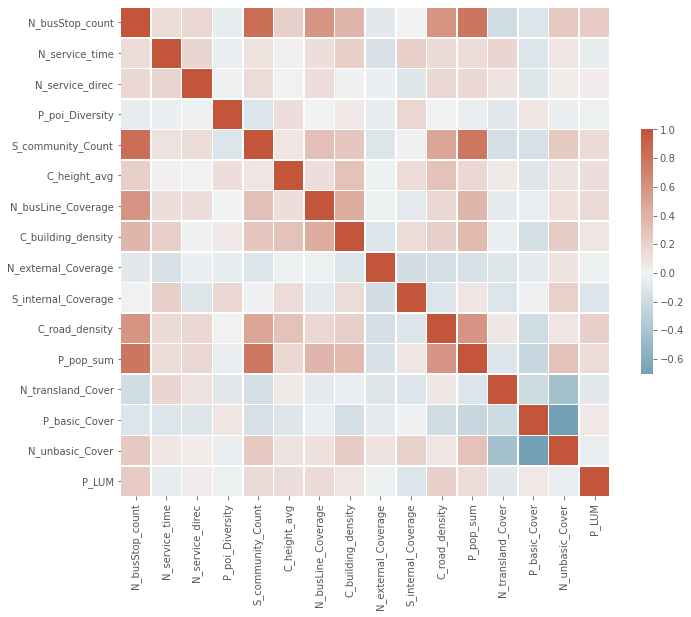

In [132]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot1=sns.heatmap(corrMatrix,  cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [133]:
plot1.figure.savefig("corr.png",dpi=300)

In [137]:
gz_area3.rename(columns={'N_unbasic_Cover':'P_unbasic_Cover'},inplace=True)

In [138]:
gz_area3.to_csv('gz_all_variables.csv',encoding='utf-8',index=False)

In [139]:
#尝试PCA
gz_PCA=gz_area3.copy()

In [136]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [211]:
features = ['N_busStop_count', 'N_service_time', 'N_service_direc', 'N_busLine_Coverage','N_external_Coverage','N_transland_Cover'
           ,'P_poi_Diversity', 'P_pop_sum', 'P_basic_Cover', 'P_unbasic_Cover','P_LUM'
           ,'S_community_Count','S_internal_Coverage','C_height_avg','C_building_density','C_road_density']
# Separating out the features
x = gz_PCA.loc[:, features].values
# Separating out the target
y = gz_PCA.loc[:,['id']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [212]:
gz_pca_all = PCA(n_components=10)
principalComponents = gz_pca_all.fit_transform(x)
gz_pca_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4',
                         'principal component 5', 'principal component 6','principal component 7', 'principal component 8',
                         'principal component 9', 'principal component 10'])

In [213]:
gz_pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,-0.2187,1.7653,-0.0249,1.2595,1.2674,0.3157,1.7087,0.1010,0.1984,1.1331
1,-0.3696,0.4555,-0.6726,0.6527,0.9627,0.0471,-0.6656,-0.3524,0.1711,0.0430
2,0.0857,0.0834,-1.3004,0.6464,0.5415,0.7910,-0.1734,0.0918,0.4858,-0.5332
3,0.8218,-1.2665,-0.5969,0.6256,0.6761,0.0094,-0.7055,-0.3151,-0.1121,-0.6936
4,1.9911,-1.3457,0.2571,1.3621,1.1000,-1.6607,0.8183,-0.8552,-0.2112,0.6344


In [214]:
gz_pca_all.explained_variance_ratio_

array([0.24871867, 0.1074318 , 0.09521623, 0.09075294, 0.07355163,
       0.06560022, 0.0613112 , 0.05364651, 0.04902682, 0.04388852])

In [156]:
gz_pca_all.n_components_

10

In [304]:
#PCA for Node
features_N = ['N_busStop_count', 'N_service_time', 'N_service_direc', 'N_busLine_Coverage','N_external_Coverage','N_transland_Cover'
           ]
# Separating out the features
x_N = gz_PCA.loc[:, features_N].values
# Separating out the target
y_N = gz_PCA.loc[:,['id']].values
# Standardizing the features
x_N =MinMaxScaler().fit_transform(x_N)#MinMaxScaler/StandardScaler

In [208]:
gz_pca_N = PCA(n_components=6)
principalComponents_N = gz_pca_N.fit_transform(x_N)
gz_pca_df_N = pd.DataFrame(data = principalComponents_N
             , columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4'
                         ,'principal component 5', 'principal component 6'])

In [209]:
gz_pca_N.explained_variance_ratio_

array([0.33644854, 0.24092281, 0.14606542, 0.12664326, 0.09234485,
       0.05757512])

In [181]:
#PCA for Plcae
features_P = ['P_poi_Diversity', 'P_pop_sum', 'P_basic_Cover', 'P_unbasic_Cover','P_LUM'
           ]
# Separating out the features
x_P = gz_PCA.loc[:, features_P].values
# Separating out the target
y_P = gz_PCA.loc[:,['id']].values
# Standardizing the features
x_P = MinMaxScaler().fit_transform(x_P)

In [182]:
gz_pca_P = PCA(n_components=4)
principalComponents_P = gz_pca_P.fit_transform(x_P)
gz_pca_df_P = pd.DataFrame(data = principalComponents_P
             , columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4'
                         ])

In [183]:
gz_pca_P.explained_variance_ratio_

array([0.43085864, 0.26664209, 0.15815591, 0.08037164])

In [177]:
#PCA for Settlement
features_S = ['S_community_Count','S_internal_Coverage'
           ]
# Separating out the features
x_S = gz_PCA.loc[:, features_S].values
# Separating out the target
y_S = gz_PCA.loc[:,['id']].values
# Standardizing the features
x_S = MinMaxScaler().fit_transform(x_S)

In [178]:
gz_pca_S = PCA(n_components=2)
principalComponents_S = gz_pca_S.fit_transform(x_S)
gz_pca_df_S = pd.DataFrame(data = principalComponents_S
             , columns = ['principal component 1', 'principal component 2'])

In [179]:
gz_pca_S.explained_variance_ratio_

array([0.60477555, 0.39522445])

In [174]:
#PCA for Container
features_C = ['C_height_avg','C_building_density','C_road_density'
           ]
# Separating out the features
x_C = gz_PCA.loc[:, features_C].values
# Separating out the target
y_C = gz_PCA.loc[:,['id']].values
# Standardizing the features
x_C = MinMaxScaler().fit_transform(x_C)

In [175]:
gz_pca_C = PCA(n_components=3)
principalComponents_C = gz_pca_C.fit_transform(x_C)
gz_pca_df_C = pd.DataFrame(data = principalComponents_C
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [180]:
gz_pca_C.explained_variance_ratio_

array([0.6206879, 0.2358419, 0.1434702])

In [198]:
#mcdm-CRITIC METHOD

In [197]:
pip install mcdm

     |████████████████████████████████| 69 kB 267 kB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 161 kB/s eta 0:00:01    |████                            | 1.9 MB 885 kB/s eta 0:00:16     |██████                          | 3.0 MB 994 kB/s eta 0:00:13     |██████████▌                     | 5.2 MB 1.1 MB/s eta 0:00:10     |███████████▏                    | 5.5 MB 1.1 MB/s eta 0:00:10     |██████████████▎                 | 7.0 MB 1.8 MB/s eta 0:00:05     |██████████████▌                 | 7.1 MB 1.8 MB/s eta 0:00:05     |███████████████▏                | 7.4 MB 1.8 MB/s eta 0:00:05     |████████████████████████        | 11.8 MB 1.7 MB/s eta 0:00:03     |████████████████████████▌       | 12.0 MB 1.7 MB/s eta 0:00:03     |████████████████████████▊       | 12.1 MB 1.7 MB/s eta 0:00:03     |█████████████████████████▏      | 12.3 MB 1.7 MB/s eta 0:00:03     |█████████████████████████▊      | 12.6 MB 1.7 MB/s eta 0:00:02     |██████████████████████████▏     | 12.8 MB 1.7 MB/s 

In [199]:
import mcdm

In [202]:
help(mcdm.weighting.critic)

Help on function critic in module mcdm.weighting.critic:

critic(z_matrix, c_method='Pearson')
    Python implementation of the CRITIC weighting method.
    
    For more information, see the following publication:
      * D. Diakoulaki, G. Mavrotas, and L. Papayannakis, "Determining
        objective weights in multiple criteria problems: The CRITIC method,"
        Computers & Operations Research, vol. 22, no. 7, pp. 763--770, 1995.
        DOI: 10.1016/0305-0548(94)00059-H.



In [220]:
Node_arry=mcdm.weighting.critic(x_N)
Node_wgt=Node_arry.tolist()

In [272]:
Place_arry=mcdm.weighting.critic(x_P)
Place_wgt=Place_arry.tolist()

In [222]:
Settlement_arry=mcdm.weighting.critic(x_S)
Settlement_wgt=Settlement_arry.tolist()

In [223]:
Container_arry=mcdm.weighting.critic(x_C)
Container_wgt=Container_arry.tolist()

In [225]:
Node_wgt[0]

0.1691359566538255

In [253]:
Node['0_0']=Node_wgt[0]
Node['0_1']=Node_wgt[1]
Node['0_2']=Node_wgt[2]
Node['0_3']=Node_wgt[3]
Node['0_4']=Node_wgt[4]
Node['0_5']=Node_wgt[5]

In [262]:
Node.rename(columns={'0':'a',
                      '1':'b',
                      '2':'c',
                      '3':'d',
                      '4':'e',
                      '5':'f'}, inplace=True)

In [264]:
###测量correlation
gz_index=gz_area3.copy()
gz_index= gz_index.drop(['lng84','lat84','geometry','line_name','station_name','lng','lat','area','road_length_x'],axis=1)

In [265]:
gz_index.columns

Index(['id', 'N_busStop_count', 'N_service_time', 'N_service_direc',
       'P_poi_Diversity', 'S_community_Count', 'C_height_avg',
       'N_busLine_Coverage', 'C_building_density', 'N_external_Coverage',
       'S_internal_Coverage', 'C_road_density', 'P_pop_sum',
       'N_transland_Cover', 'P_basic_Cover', 'P_unbasic_Cover', 'P_LUM'],
      dtype='object')

In [268]:
scaler = MinMaxScaler()
# fit and transform the data
gz_norm = pd.DataFrame(scaler.fit_transform(gz_index), columns=gz_index.columns)

In [273]:
#计算各维度index
gz_norm['Node_index']=gz_norm.N_busStop_count*Node_wgt[0]+gz_norm.N_service_time*Node_wgt[1]+gz_norm.N_service_direc*Node_wgt[2]+gz_norm.N_busLine_Coverage*Node_wgt[3]+gz_norm.N_external_Coverage*Node_wgt[4]+gz_norm.N_transland_Cover*Node_wgt[5]
gz_norm['Place_index']=gz_norm.P_poi_Diversity*Place_wgt[0]+gz_norm.P_pop_sum*Place_wgt[1]+gz_norm.P_basic_Cover*Node_wgt[2]+gz_norm.P_unbasic_Cover*Place_wgt[3]+gz_norm.P_LUM*Place_wgt[4]
gz_norm['Settlement_index']=gz_norm.S_community_Count*Settlement_wgt[0]+gz_norm.S_internal_Coverage*Settlement_wgt[1]
gz_norm['Container_index']=gz_norm.C_height_avg*Container_wgt[0]+gz_norm.C_building_density*Container_wgt[1]+gz_norm.C_road_density*Container_wgt[2]

In [281]:
gz_final=gz_norm[['Node_index','Place_index','Settlement_index','Container_index','id']]

In [283]:
gz_final.head()

,Node_index,Place_index,Settlement_index,Container_index,id
0,0.3471,0.4052,0.2016,0.1421,1
1,0.2620,0.4184,0.1349,0.1831,2
2,0.3274,0.4447,0.1231,0.1731,3
3,0.3188,0.4751,0.1988,0.1788,4
4,0.3226,0.4969,0.4399,0.2621,5


In [282]:
gz_final['uid']=gz_final.index.values+1
gz_final=gz_final.drop(['id'],axis=1)
gz_final.rename(columns={'uid':'id'},inplace=True)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [291]:
gz_final_area=pd.merge(gz_area3,gz_final,on='id',how='left')
gz_temp=gz_final_area[['id','lng','Node_index','Place_index','Settlement_index','Container_index']]

In [292]:
gz_final_station=pd.merge(gz_station,gz_temp,on='lng',how='left')

In [293]:
gz_final_station.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   line_name         200 non-null    object  
 1   station_na        200 non-null    object  
 2   lng               200 non-null    object  
 3   lat               200 non-null    object  
 4   lng84             200 non-null    object  
 5   lat84             200 non-null    object  
 6   geometry          200 non-null    geometry
 7   id                200 non-null    int64   
 8   Node_index        200 non-null    float64 
 9   Place_index       200 non-null    float64 
 10  Settlement_index  200 non-null    float64 
 11  Container_index   200 non-null    float64 
dtypes: float64(4), geometry(1), int64(1), object(6)
memory usage: 30.3+ KB


In [300]:
gz_final_station = gz_final_station.astype({"line_name":'string', "station_na":'string',"lat":'float64',"lng":'float64',"lat84":'float64',"lng84":'float64'})

In [301]:
gz_final_station.to_file("gz_station_withindex.shp")

In [298]:
gz_final_area.to_file("gz_area_withindex.shp")

In [302]:
gz_line.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   line_name     14 non-null     object  
 1   start_time    14 non-null     object  
 2   end_time      14 non-null     object  
 3   start_stop    14 non-null     object  
 4   end_stop      14 non-null     object  
 5   distance      14 non-null     object  
 6   basic_pric    14 non-null     object  
 7   total_pric    14 non-null     object  
 8   geometry      14 non-null     geometry
 9   service_time  14 non-null     object  
dtypes: geometry(1), object(9)
memory usage: 1.2+ KB


In [303]:
gz_line.to_file('gz_line.shp')

ValueError: Invalid field type <class 'bytes'>